In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import nltk
from collections import Counter
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
import string
import re
nltk.download('stopwords')
stop=set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Planned structure:
* Loading the data 
* Format them and combine
* Preprocess and plot (It should be wiser to first plot some of the information about our data and plot again after the preprocess, like avg token size maybe?)

## Data Preprocessing and EDA 

### Loading the datasets

#### FEVER Dataset
Requires some preprocess, these are mostly used for fact extraction and verification so it might be useful for training?

In [25]:
fever_obj = pd.read_json("datasets/FEVER/train.jsonl", lines=True)

In [26]:
fever_obj

,id,verifiable,label,claim,evidence
0,75397,VERIFIABLE,SUPPORTS,Nikolaj Coster-Waldau worked with the Fox Broa...,"[[[92206, 104971, Nikolaj_Coster-Waldau, 7], [..."
1,150448,VERIFIABLE,SUPPORTS,Roman Atwood is a content creator.,"[[[174271, 187498, Roman_Atwood, 1]], [[174271..."
2,214861,VERIFIABLE,SUPPORTS,"History of art includes architecture, dance, s...","[[[255136, 254645, History_of_art, 2]]]"
3,156709,VERIFIABLE,REFUTES,Adrienne Bailon is an accountant.,"[[[180804, 193183, Adrienne_Bailon, 0]]]"
4,83235,NOT VERIFIABLE,NOT ENOUGH INFO,System of a Down briefly disbanded in limbo.,"[[[100277, None, None, None]]]"
...,...,...,...,...,...
145444,75062,VERIFIABLE,REFUTES,Led Zeppelin released an eponymous debut album...,"[[[91851, 104659, Led_Zeppelin, 6], [91851, 10..."
145445,149256,VERIFIABLE,SUPPORTS,Taal was romantic.,"[[[292586, 285327, Taal_-LRB-film-RRB-, 0]], [..."
145446,13287,VERIFIABLE,SUPPORTS,Her stars American actress Rooney Mara.,"[[[28520, 34848, Her_-LRB-film-RRB-, 3], [2852..."
145447,13114,VERIFIABLE,SUPPORTS,J. R. R. Tolkien created Gimli.,"[[[28359, 34669, Gimli_-LRB-Middle-earth-RRB-,..."


In [27]:
fever_obj["label"].value_counts()

SUPPORTS           80035
NOT ENOUGH INFO    35639
REFUTES            29775
Name: label, dtype: int64

#### LIAR Dataset
Column names are missing, labels are weird (half-true, pants-fire, etc.), consists somewhat irrelevant information.

In [28]:
liar_dataset = pd.read_csv("datasets/liar/train.tsv", sep ='\t', header=None)

In [29]:
liar_dataset

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10235,5473.json,mostly-true,There are a larger number of shark attacks in ...,"animals,elections",aclu-florida,NaN,Florida,none,0.0,1.0,1.0,1.0,0.0,"interview on ""The Colbert Report"""
10236,3408.json,mostly-true,Democrats have now become the party of the [At...,elections,alan-powell,NaN,Georgia,republican,0.0,0.0,0.0,1.0,0.0,an interview
10237,3959.json,half-true,Says an alternative to Social Security that op...,"retirement,social-security",herman-cain,NaN,Georgia,republican,4.0,11.0,5.0,3.0,3.0,a Republican presidential debate
10238,2253.json,false,On lifting the U.S. Cuban embargo and allowing...,"florida,foreign-policy",jeff-greene,NaN,Florida,democrat,3.0,1.0,3.0,0.0,0.0,a televised debate on Miami's WPLG-10 against ...


In [30]:
# very weird labels
liar_dataset[1].value_counts()

half-true      2114
false          1995
mostly-true    1962
true           1676
barely-true    1654
pants-fire      839
Name: 1, dtype: int64

#### FakeNews
Formatted greatly, does not require that much of a preprocess.

In [31]:
fake_news = pd.read_csv("datasets/fake_news/train.csv")

In [32]:
fake_news

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \r\nAn Iranian woman has been sentenced ...,1
...,...,...,...,...,...
20795,20795,Rapper T.I.: Trump a ’Poster Child For White S...,Jerome Hudson,Rapper T. I. unloaded on black celebrities who...,0
20796,20796,"N.F.L. Playoffs: Schedule, Matchups and Odds -...",Benjamin Hoffman,When the Green Bay Packers lost to the Washing...,0
20797,20797,Macy’s Is Said to Receive Takeover Approach by...,Michael J. de la Merced and Rachel Abrams,The Macy’s of today grew from the union of sev...,0
20798,20798,"NATO, Russia To Hold Parallel Exercises In Bal...",Alex Ansary,"NATO, Russia To Hold Parallel Exercises In Bal...",1


In [33]:
fake_news['label'].value_counts()

1    10413
0    10387
Name: label, dtype: int64

In [34]:
fake_news_clean = fake_news.drop(columns=['id', 'author'])
fake_news_clean

,title,text,label
0,House Dem Aide: We Didn’t Even See Comey’s Let...,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Ever get the feeling your life circles the rou...,0
2,Why the Truth Might Get You Fired,"Why the Truth Might Get You Fired October 29, ...",1
3,15 Civilians Killed In Single US Airstrike Hav...,Videos 15 Civilians Killed In Single US Airstr...,1
4,Iranian woman jailed for fictional unpublished...,Print \r\nAn Iranian woman has been sentenced ...,1
...,...,...,...
20795,Rapper T.I.: Trump a ’Poster Child For White S...,Rapper T. I. unloaded on black celebrities who...,0
20796,"N.F.L. Playoffs: Schedule, Matchups and Odds -...",When the Green Bay Packers lost to the Washing...,0
20797,Macy’s Is Said to Receive Takeover Approach by...,The Macy’s of today grew from the union of sev...,0
20798,"NATO, Russia To Hold Parallel Exercises In Bal...","NATO, Russia To Hold Parallel Exercises In Bal...",1


#### Fake and Real News Dataset
Formatted greatly, includes subject column that gives info about the text. 21k True 23k False

In [35]:
fake_and_real_T = pd.read_csv("datasets/fake_and_real_news_dataset/True.csv")
fake_and_real_F = pd.read_csv("datasets/fake_and_real_news_dataset/Fake.csv")

In [36]:
fake_and_real_T

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"
...,...,...,...,...
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017"
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017"
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017"
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017"


In [37]:
fake_and_real_T['label'] = 1

In [38]:
fake_and_real_F

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"
...,...,...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016"
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016"
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016"
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016"


In [39]:
fake_and_real_F['label'] = 0

In [40]:
fake_and_real_combined = pd.concat([fake_and_real_T, fake_and_real_F]).sample(frac=1).reset_index(drop=True)
fake_and_real_combined.drop(columns='date', inplace=True)
fake_and_real_combined

,title,text,subject,label
0,PUTZ OBAMA Calls Electoral College A ‘Vestige’...,,politics,0
1,Trump Screams ‘FAKE NEWS’ Over His Tax Return...,The White House may have verified the legitima...,News,0
2,"Mike Pence Cancels ANOTHER Trump Event, Campa...",Donald Trump s lewd comments about sexually as...,News,0
3,It Only Takes Chris Hayes One Tweet To Comple...,It s become increasingly common among Republic...,News,0
4,CNN’S DON LEMON Tries to Blame Trump…Cuts Off ...,Don Lemon tries to blame Donald Trump for the ...,left-news,0
...,...,...,...,...
44893,Rosie O’Donnell Thinks Martial Law is in Order...,21st Century Wire says Arguably irrelevant Hol...,US_News,0
44894,Japan health ministry to water down proposal o...,TOKYO (Reuters) - Japan s health ministry is l...,worldnews,1
44895,Lebanon's Jumblatt criticizes Saudi over Hariri,BEIRUT (Reuters) - Top Lebanese Druze politici...,worldnews,1
44896,(VIDEO) KRAUTHAMMER: FORMER CIA DEPUTY DIRECTO...,,politics,0


### Formatting the DataFrames and Combining

* Our three datasets do not share the same informatics, some of them have very distinct columns (LIAR) while some of them only have text and label (Fake and Real dataset).
* Since most of the unnecessary information does not represent our data that good, we will only focus on text and label while we apply preprocessing and other operations on them

#### LIAR

TODO:
* Give some insight about the dataset
* Explain why we are dropping the columns

In [41]:
liar_dataset.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN


In [42]:
liar_dataset.shape

(10240, 14)

In [43]:
liar_dataset.dtypes

0      object
1      object
2      object
3      object
4      object
5      object
6      object
7      object
8     float64
9     float64
10    float64
11    float64
12    float64
13     object
dtype: object

##### Dropping NaN values

In [44]:
liar_dataset.isnull().sum()

0        0
1        0
2        0
3        2
4        2
5     2897
6     2208
7        2
8        2
9        2
10       2
11       2
12       2
13     102
dtype: int64

In [45]:
liar_dataset.dropna(inplace=True)
liar_dataset.isnull().sum()

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
dtype: int64

##### Renaming the columns

The original column names weren't available in the csv file but it's available in the README file of the LIAR dataset. For the sake of better insight about the data we will re-map the columns into their original names

In [46]:
# liar dataset
column_mapping = {
    0: 'statement_ID',
    1: 'label',
    2: 'statement',
    3: 'subject',
    4: 'speaker',
    5: 'speaker_job_title',
    6: 'state_info',
    7: 'party_affiliation',
    8: 'barely_true_counts',
    9: 'false_counts',
    10: 'half_true_counts',
    11: 'mostly_true_counts',
    12: 'pants_on_fire_counts',
    13: 'context'
}

liar_dataset = liar_dataset.rename(columns=column_mapping)
liar_dataset.head(n=2)

,statement_ID,label,statement,subject,speaker,speaker_job_title,state_info,party_affiliation,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,context
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.


##### Dropping irrelevant columns
Explain why we are dropping these columns

In [47]:
drop_columns = ['statement_ID', 'speaker_job_title', 'state_info', 'party_affiliation',
                "barely_true_counts", "false_counts", "half_true_counts", "mostly_true_counts", "pants_on_fire_counts", "speaker", "context", "subject"]

liar_clean = liar_dataset.drop(columns=drop_columns)
liar_clean.rename(columns={'statement':'text'}, inplace=True)
liar_clean


,label,text
0,false,Says the Annies List political group supports ...
1,half-true,When did the decline of coal start? It started...
2,mostly-true,"Hillary Clinton agrees with John McCain ""by vo..."
5,true,The Chicago Bears have had more starting quart...
7,half-true,I'm the only person on this stage who has work...
...,...,...
10227,pants-fire,"Recently though, the media has reported on tho..."
10228,barely-true,Stopped by Smiley Cookie to pick up some great...
10230,barely-true,The Supreme Courts views are radically out of ...
10231,half-true,"When it comes to the state deficit, Wisconsin ..."


##### Value counts of labels and mapping them as binary
Explain why half-true and barely-true are useless since they will cause problem with other datasets (We need binary classification)

In [48]:
liar_clean['label'].value_counts()

half-true      1413
mostly-true    1363
false          1305
true           1154
barely-true    1052
pants-fire      437
Name: label, dtype: int64

Explain the mapping maybe

In [49]:
label_mapping = {
    'true': 3,
    'mostly-true': 2,
    'half-true':1,
    'barely-true': 0,
    'false': -1,
    'pants-fire': -2
}

liar_clean_multi = liar_clean.copy()
liar_clean_multi['label'] = liar_clean['label'].map(label_mapping)
liar_clean_multi = liar_clean_multi.reindex(columns=sorted(liar_clean_multi.columns, reverse=True))
liar_clean_multi['label'].value_counts()

 1    1413
 2    1363
-1    1305
 3    1154
 0    1052
-2     437
Name: label, dtype: int64

In [50]:
liar_clean_binary = liar_clean[~liar_clean['label'].isin(['half-true', 'barely-true'])]
label_mapping = {
    'mostly-true': 1,
    'true': 1,
    'false': 0,
    'pants-fire': 0
}

liar_clean_binary['label'] = liar_clean_binary['label'].map(label_mapping)
liar_clean_binary = liar_clean_binary.reindex(columns=sorted(liar_clean_binary.columns, reverse=True))
liar_clean_binary['label'].value_counts()

C:\Users\User\AppData\Local\Temp\ipykernel_13076\778657478.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  liar_clean_binary['label'] = liar_clean_binary['label'].map(label_mapping)


1    2517
0    1742
Name: label, dtype: int64

In [51]:
liar_clean_binary

,text,label
0,Says the Annies List political group supports ...,0
2,"Hillary Clinton agrees with John McCain ""by vo...",1
5,The Chicago Bears have had more starting quart...,1
9,Says GOP primary opponents Glenn Grothman and ...,1
10,"For the first time in history, the share of th...",1
...,...,...
10222,"For the first time since the Korean War, total...",1
10223,Says Rick Perry turned down our invitation to ...,1
10226,The proudest accomplishment (of my tenure) was...,1
10227,"Recently though, the media has reported on tho...",0


#### Fake and Real News

TODO:
* Give some insight about the dataset
* Explain why we are dropping the columns

In [52]:
fake_and_real_combined.head(5)

,title,text,subject,label
0,PUTZ OBAMA Calls Electoral College A ‘Vestige’...,,politics,0
1,Trump Screams ‘FAKE NEWS’ Over His Tax Return...,The White House may have verified the legitima...,News,0
2,"Mike Pence Cancels ANOTHER Trump Event, Campa...",Donald Trump s lewd comments about sexually as...,News,0
3,It Only Takes Chris Hayes One Tweet To Comple...,It s become increasingly common among Republic...,News,0
4,CNN’S DON LEMON Tries to Blame Trump…Cuts Off ...,Don Lemon tries to blame Donald Trump for the ...,left-news,0


In [53]:
fake_and_real_combined.isnull().sum()

title      0
text       0
subject    0
label      0
dtype: int64

In [54]:
fake_and_real_clean = fake_and_real_combined.copy()

fake_and_real_clean['text'] = fake_and_real_combined['title'] + ' ' + fake_and_real_combined['text']
drop_columns = ['title','subject']
fake_and_real_clean = fake_and_real_clean.drop(columns=drop_columns)
fake_and_real_clean.head(n=5)

,text,label
0,PUTZ OBAMA Calls Electoral College A ‘Vestige’...,0
1,Trump Screams ‘FAKE NEWS’ Over His Tax Return...,0
2,"Mike Pence Cancels ANOTHER Trump Event, Campa...",0
3,It Only Takes Chris Hayes One Tweet To Comple...,0
4,CNN’S DON LEMON Tries to Blame Trump…Cuts Off ...,0


#### FakeNews

TODO:
* Give some insight about the dataset
* Explain why we are dropping the columns

In [55]:
# fakenews 
fake_news_clean.head(5)

,title,text,label
0,House Dem Aide: We Didn’t Even See Comey’s Let...,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Ever get the feeling your life circles the rou...,0
2,Why the Truth Might Get You Fired,"Why the Truth Might Get You Fired October 29, ...",1
3,15 Civilians Killed In Single US Airstrike Hav...,Videos 15 Civilians Killed In Single US Airstr...,1
4,Iranian woman jailed for fictional unpublished...,Print \r\nAn Iranian woman has been sentenced ...,1


##### Dropping NaN values

In [56]:
fake_news_clean.isnull().sum()

title    558
text      39
label      0
dtype: int64

In [57]:
fake_news_clean.dropna(inplace=True)
fake_news_clean.isnull().sum()

title    0
text     0
label    0
dtype: int64

##### Dropping irrelevant columns

In [58]:
drop_columns = ['title']
fake_news_clean = fake_news_clean.drop(columns=drop_columns)

In [59]:
fake_news_clean.head(n=5)

,text,label
0,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,Ever get the feeling your life circles the rou...,0
2,"Why the Truth Might Get You Fired October 29, ...",1
3,Videos 15 Civilians Killed In Single US Airstr...,1
4,Print \r\nAn Iranian woman has been sentenced ...,1


#### Combining all three datasets

In [60]:
text_dataset = pd.concat([liar_clean_binary, fake_and_real_clean, fake_news_clean], ignore_index=True)
text_dataset

,text,label
0,Says the Annies List political group supports ...,0
1,"Hillary Clinton agrees with John McCain ""by vo...",1
2,The Chicago Bears have had more starting quart...,1
3,Says GOP primary opponents Glenn Grothman and ...,1
4,"For the first time in history, the share of th...",1
...,...,...
69355,Rapper T. I. unloaded on black celebrities who...,0
69356,When the Green Bay Packers lost to the Washing...,0
69357,The Macy’s of today grew from the union of sev...,0
69358,"NATO, Russia To Hold Parallel Exercises In Bal...",1


In [61]:
text_dataset.isnull().sum()

text     0
label    0
dtype: int64

### Data Preprocessing

* Explain why we are removing punctuations, making them lowercase, removing stop words, clean them and potentially why we vectorize/tokenize them.

In [62]:
text_dataset.sample(n=5)

,text,label
50718,"Más de 10 países de la OTAN, dispuestos a refo...",1
11778,HOUSE FREEDOM CAUCUS Pressured By Very Familia...,0
31928,Boiler Room EP #85 – The Return of the Social ...,0
68497,Bombshell: Fox News Reports FBI To Move To “...,1
28552,Shooting Reported At Capitol; Gunman In Custo...,0


##### Calculating word and sentence based statistics for EDA 

In [63]:
def word_count(sentence):
    sentence_list = sentence.split()
    return len(sentence_list)

def avg_word_length(sentence):
    words = sentence.split()
    word_lengths = [len(word) for word in words if word.isalpha()]
    if len(word_lengths) > 0:
        return sum(word_lengths) / len(word_lengths)
    else:
        return 0


text_dataset['sentence_length'] = text_dataset['text'].apply(lambda x: sum(len(word) for word in x.split()))
text_dataset['word_count'] = text_dataset['text'].apply(word_count)
text_dataset['avg_word_length'] = text_dataset['text'].apply(avg_word_length)
text_dataset['text'] = text_dataset['text'].str.lower()
text_dataset.head(10)

,text,label,sentence_length,word_count,avg_word_length
0,says the annies list political group supports ...,0,72,11,5.555556
1,"hillary clinton agrees with john mccain ""by vo...",1,87,19,4.588235
2,the chicago bears have had more starting quart...,1,129,27,4.791667
3,says gop primary opponents glenn grothman and ...,1,112,21,5.368421
4,"for the first time in history, the share of th...",1,96,21,4.263158
5,when mitt romney was governor of massachusetts...,0,103,22,3.947368
6,mccain opposed a requirement that the governme...,1,127,19,5.066667
7,"almost 100,000 people left puerto rico last year.",1,42,8,5.000000
8,women and men both are making less when you ad...,0,98,20,4.684211
9,we just had the best year for the auto industr...,1,57,14,3.769231


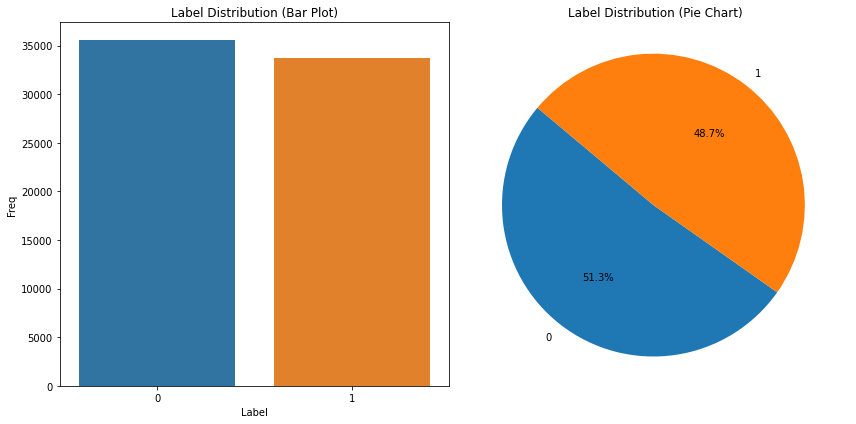

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(12, 6))


labels = text_dataset['label'].value_counts().index
counts = text_dataset['label'].value_counts().values


sns.barplot(x=labels, y=counts, ax=axes[0])
axes[0].set_xlabel('Label')
axes[0].set_ylabel('Freq')
axes[0].set_title('Label Distribution (Bar Plot)')

axes[1].pie(counts, labels=labels, autopct='%1.1f%%', startangle=140)
axes[1].axis('equal')
axes[1].set_title('Label Distribution (Pie Chart)')

plt.tight_layout()
plt.show()


##### Most frequent words and removing the stopwords

TODO: Explain what stopwords are and why are removing them

In [79]:
corpus=[]

sentences_token = text_dataset['text'].str.split().values.tolist()
corpus=[word for i in sentences_token for word in i]
counter=Counter(corpus)
most_freq = counter.most_common()

words_list, count_lists= [], []
for word,count in most_freq:
    words_list.append(word)
    count_lists.append(count)
    if len(words_list) == 10:
        break;

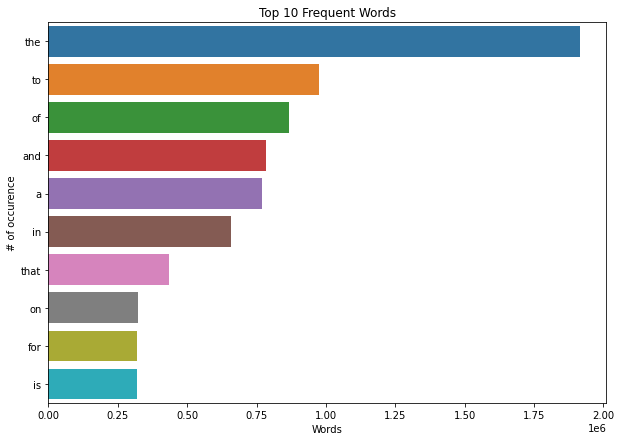

In [82]:
plt.figure(figsize=(10,7))    
sns.barplot(x=count_lists,y=words_list)
plt.title('Top 10 Frequent Words')
plt.xlabel('Words')
plt.ylabel('# of occurence')
plt.show()

In [89]:
def remove_stopwords_and_clean(text):
    stop = set(stopwords.words('english'))
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop]
    final_text = " ".join(filtered_words)
    final_text = re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", final_text)
    return " ".join(filtered_words)

text_dataset['clean_text'] = text_dataset['text'].apply(remove_stopwords_and_clean)
text_dataset

,text,label,sentence_length,word_count,avg_word_length,clean_text
0,says the annies list political group supports ...,0,72,11,5.555556,says annies list political group supports thir...
1,"hillary clinton agrees with john mccain ""by vo...",1,87,19,4.588235,"hillary clinton agrees john mccain ""by voting ..."
2,the chicago bears have had more starting quart...,1,129,27,4.791667,chicago bears starting quarterbacks last 10 ye...
3,says gop primary opponents glenn grothman and ...,1,112,21,5.368421,says gop primary opponents glenn grothman joe ...
4,"for the first time in history, the share of th...",1,96,21,4.263158,"first time history, share national popular vot..."
...,...,...,...,...,...,...
69355,rapper t. i. unloaded on black celebrities who...,0,1493,307,4.729839,rapper t. i. unloaded black celebrities met do...
69356,when the green bay packers lost to the washing...,0,4878,1120,4.326733,green bay packers lost washington redskins wee...
69357,the macy’s of today grew from the union of sev...,0,3973,801,4.615385,macy’s today grew union several great names am...
69358,"nato, russia to hold parallel exercises in bal...",1,1494,267,5.248889,"nato, russia hold parallel exercises balkans 1..."


After removing the stopwords

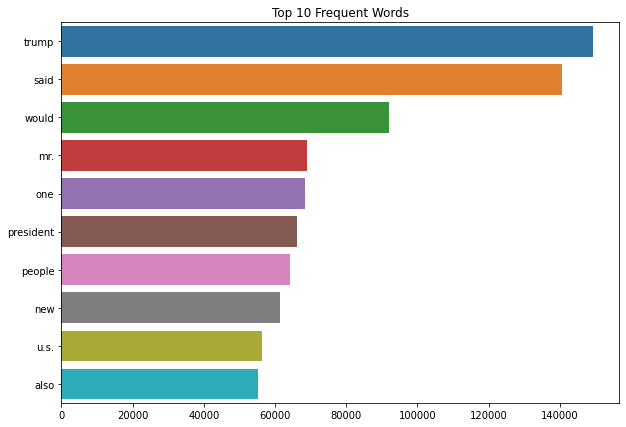

In [83]:
sentences_token = text_dataset['clean_text'].str.split().values.tolist()
corpus = [word for i in sentences_token for word in i]
counter = Counter(corpus)
most_freq = counter.most_common()

words_list, count_lists= [], []
for word,count in most_freq:
    words_list.append(word)
    count_lists.append(count)
    if len(words_list) == 10:
        break;
plt.figure(figsize=(10,7))
sns.barplot(x=count_lists,y=words_list)
plt.title('Top 10 Frequent Words')
plt.show()

#### Plots
Requires additional plots that gives us better insight

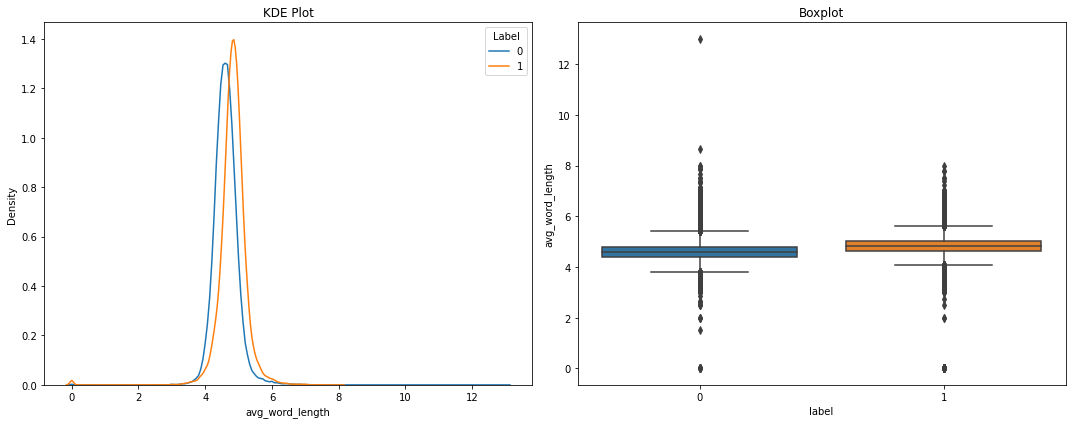

In [69]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

for label in text_dataset['label'].unique():
    sns.kdeplot(data=text_dataset[text_dataset['label'] == label]['avg_word_length'], label=label, ax=ax1)
ax1.set_title('KDE Plot')
ax1.legend(title='Label', labels=text_dataset['label'].unique())

sns.boxplot(x='label', y='avg_word_length', data=text_dataset, ax=ax2)
ax2.set_title('Boxplot')

plt.tight_layout()
plt.show()


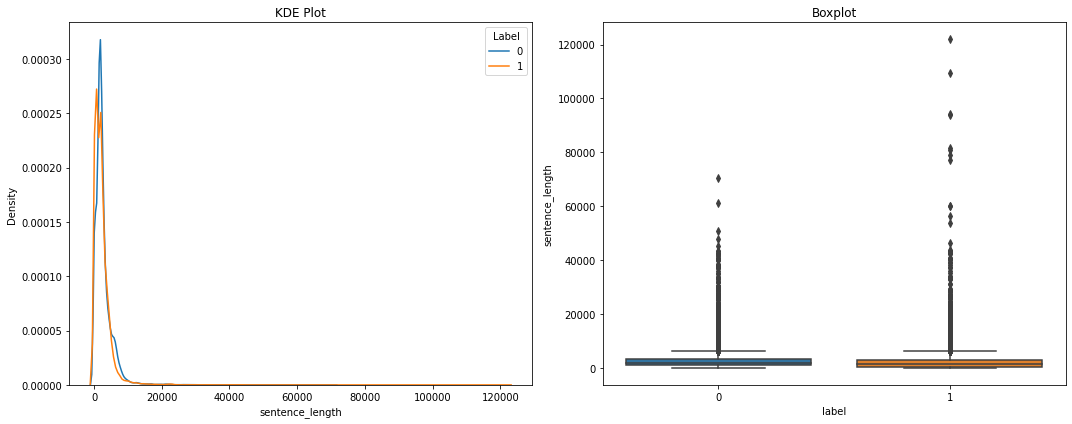

In [70]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

for label in text_dataset['label'].unique():
    sns.kdeplot(data=text_dataset[text_dataset['label'] == label]['sentence_length'], label=label, ax=ax1)
ax1.set_title('KDE Plot')
ax1.legend(title='Label', labels=text_dataset['label'].unique())

sns.boxplot(x='label', y='sentence_length', data=text_dataset, ax=ax2)
ax2.set_title('Boxplot')

plt.tight_layout()
plt.show()


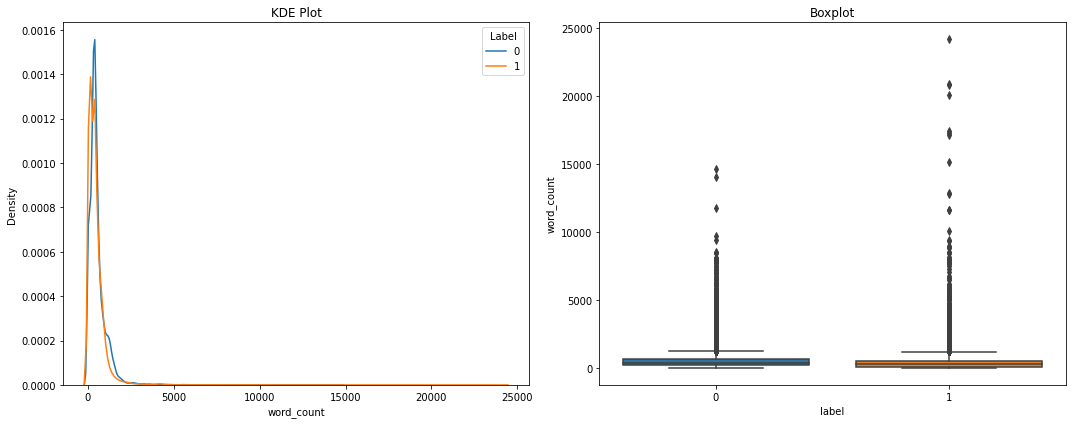

In [71]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

for label in text_dataset['label'].unique():
    sns.kdeplot(data=text_dataset[text_dataset['label'] == label]['word_count'], label=label, ax=ax1)
ax1.set_title('KDE Plot')
ax1.legend(title='Label', labels=text_dataset['label'].unique())

sns.boxplot(x='label', y='word_count', data=text_dataset, ax=ax2)
ax2.set_title('Boxplot')

plt.tight_layout()
plt.show()


##### Data Cleaning and tokenization